<header style="width:100%;position:relative">
  <div style="width:80%;float:right;">
    <h1>False Political Claim Detection</h1>
    <h3>Training & Model Evaluation 2</h3>
    <h5>Grupo 2</h5>
  </div>
        <img style="width:15%;" src="./images/logo.jpg" alt="UPM" />
</header>

# 1. Importar librerias

In [3]:
# General import and load data
import pandas as pd
import numpy as np

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# Splitting
from sklearn.model_selection import train_test_split

# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_curve, roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Visualization
import matplotlib.pyplot as plt

# Time optimization
import time
# word2vec
from gensim.models import Word2Vec
import gensim
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import word_tokenize
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('punkt') 


print("Todas las librerias fueron correctamente importadas.")

Todas las librerias fueron correctamente importadas.


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rsalvatori/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rsalvatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Variables globales y funciones auxiliares

Se fija un seed para todo el documento para fijar la aleatoriedad y así obtener resultados replicables.

In [7]:
seed = 42

Función utilizado para evaluar los distintos umbrales en la curva de ROC.

In [10]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Recall:', 1 - fpr[thresholds > threshold][-1])

# 3. Carga del dataframe

Se cargan los datos de la ruta *formated/train_exportado.csv*, los cuales son los datos ya procesados por uno de nuestros compañeros.

In [14]:
url = "formated/train_exportado.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

Datos cargados correctamente



También cargamos el test que debemos predecir para Kaggle de la ruta *formated/test_exportado.csv*.

In [17]:
url = "formated/test_exportado.csv"
df_test = pd.read_csv(url)

print("Test cargado correctamente\n")

Test cargado correctamente



# 4. Seleccion de las caracteristicas

En el siguiente array se muestran todas las caracteristicas por si se decide realizar pruebas con otras *features*.

In [21]:
all_features = [
    # Identificador
    'id',

    # Etiqueta objetivo
    'label',

    # Texto original y procesado
    'statement', 'statement-raw', 'statement-lemmatize', 

    # Features derivados del texto
    'statement-ner', 'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas
    'speaker_grouped', 'speaker_job_grouped', 'state_info_grouped', 'party_group',

    # Resto de las categoricas agrupadas y codificadas
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod',

    # Variables generadas por LLM los null
    'speaker_job-llm', 'speaker_job_cod-llm',
    'state_info-llm', 'state_info_cod-llm',
    'party_affiliation-llm', 'party_affiliation_cod-llm'
]

Se seleccionan todas las categorias menos: 
* ***id***: no aporta ningún valor.
* ***label***: variable a predecir.
* ***statement***: esta *feature* esta por si nos es necesario en algun momento futuro tener el texto sin procesar.
* ***statement-lemmatize***: esta *feature* solo esta para probar en notebooks posteriores si clasifica mejor o peor con las raices de las palabras.
* ***statement-ner***: esta *feature* esta para ver si el clasificador funciona mejor con el NER por separado.
* ***speaker_grouped***, ***speaker_job_grouped***, ***state_info_grouped***, ***party_group***: suponemos que tenemos la misma información ya codificada.
* ***speaker_job-llm***, ***speaker_job_cod-llm***, ***state_info-llm***, ***state_info_cod-llm***, ***party_affiliation-llm***, ***party_affiliation_cod-llm***: esta información ya esta en otras *features*, la diferencia esta en como se tratan los nulos asi que se analizará cual funciona mejor si con LLM o sin ellos durante el apartado de clasificación.

In [24]:
selected_features = [
    # Texto
    'statement-raw',
        
    # Features derivados del texto
    'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas y codificadas
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod'
]

En caso de querer probar si funcionan mejor las de los LLM, se sustituirán por su simil. También si se quiere probar el texto lematizado se sustituira por el *raw*.

De las cuales texto es:

In [28]:
text = 'statement-raw'

Y las que no se corresponden con texto son:

In [31]:
no_text = [
    # Features derivados del texto
    'feelings',

    # One-hot encoded de los temas reagrupados del texto 
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',

    # Resto de las categoricas agrupadas y codificadas
     'speaker_grouped_cod', 'speaker_job_grouped_cod',
     'state_info_grouped_cod', 'party_group_cod'
]

Y de las cuales, numéricas son las siguientes:

In [34]:
numeric_vars = [
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod'
]

# 5. Carga de los datos y division en entrenamiento y test

Cargamos las caracteristicas seleccionadas en la variable X y el objetivo *Accept* en la variable y.

In [38]:
X = df[selected_features] 
y = df['label'].values

Se separa ya en entrenamiento y test para no falsear los datos del test al realizar el balanceo.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

A la hora de subir el modelo a Kaggle, ya se nos da dividido el entrenamiento y el test. Por ello, se utilizarán todos los datos tratados como entrenamiento (aunque también se le aplicará el mejor caso de preprocesado para cada modelo).

In [44]:
X_train_final = X
y_train_final = y

X_test_final = df_test[selected_features] 

# 6. Preprocesado

Como se menciona en el notebook dedicado al preprocesamiento, primero se tratará el texto, después se reducirá su dimensionalidad con un *PCA*, se estandarizarán las variables codificadas mediante un *StandardScaler* y, finalmente, se realizará un remuestreo mediante *SMOTE* y *RandomUnderSampler*. 

En caso de querer probar el caso de preprocesamiento 6, será necesario eliminar el *StandardScaler* junto al *ColumnTransformer*.

## 6.1 Tratamiento de los textos

### 6.1.1 Vectorización

Primero tokenizamos el texto para Word2Vec

In [51]:

# Tokeniza el texto 
#X_train_tokens = X_train[text].apply(lambda x: x.split())
#X_test_tokens = X_test[text].apply(lambda x: x.split())

X_train_tokens = X_train[text].apply(lambda x: word_tokenize(str(x)))
X_test_tokens = X_test[text].apply(lambda x: word_tokenize(str(x)))


A continuación se entrena un modelo Word2Vec utilizando los textos tokenizados del conjunto de entrenamiento. Posteriormente, se obtiene un vector representativo para cada texto calculando la media de los vectores de las palabras que aparecen en el vocabulario del modelo. Finalmente, se aplica este proceso tanto al conjunto de entrenamiento como al de test.


In [53]:
w2v_model = Word2Vec(sentences=X_train_tokens, vector_size=30, window=2, min_count=2, workers=1, seed=42)


# Palabras conocidas
vocab = set(w2v_model.wv.index_to_key)

def sentence_vector(tokens, model, size=30):
    vectors = [model.wv[w] for w in tokens if w in vocab]
    if len(vectors) == 0:
        return np.zeros(size)
    else:
        return np.mean(vectors, axis=0)

# Aplica a train y test
X_txt_train = np.vstack(X_train_tokens.apply(lambda x: sentence_vector(x, w2v_model)))
X_txt_test = np.vstack(X_test_tokens.apply(lambda x: sentence_vector(x, w2v_model)))

Después para el dataset que se utilizará para subir a Kaggle.

In [56]:
# Tokeniza el texto 
#X_train_tokens_final = X_train_final[text].apply(lambda x: x.split())
#X_test_tokens_final = X_test_final[text].apply(lambda x: x.split())

X_train_tokens_final = X_train_final[text].apply(lambda x: word_tokenize(str(x)))
X_test_tokens_final = X_test_final[text].apply(lambda x: word_tokenize(str(x)))

In [57]:
w2v_model_final = Word2Vec(sentences=X_train_tokens_final, vector_size=30, window=2, min_count=2, workers=1, seed=42)


# Palabras conocidas
vocab_final = set(w2v_model_final.wv.index_to_key)

def sentence_vector(tokens, model, size=30):
    vectors = [model.wv[w] for w in tokens if w in vocab_final]
    if len(vectors) == 0:
        return np.zeros(size)
    else:
        return np.mean(vectors, axis=0)

# Aplica a train y test
X_txt_tr_final = np.vstack(X_train_tokens_final.apply(lambda x: sentence_vector(x, w2v_model_final)))
X_txt_te_final = np.vstack(X_test_tokens_final.apply(lambda x: sentence_vector(x, w2v_model_final)))

Después de analizar la varianza explicada mediante PCA (6.1.3), se observó que un número reducido de componentes era suficiente para conservar el 95% de la varianza. Por tanto, se consideró razonable reducir también la dimensionalidad inicial de los vectores Word2Vec a 30, con el objetivo de eliminar redundancias y reducir la complejidad del modelo, minimizando así el riesgo de sobreajuste sin una pérdida significativa de información.

## 6.1.2 Unificación de características

In [61]:
# Train
X_svd_train = pd.DataFrame(X_txt_train, columns=[f"svd_{i}" for i in range(X_txt_train.shape[1])])
X_rest_train = X_train[no_text].reset_index(drop=True)

# Test
X_svd_test = pd.DataFrame(X_txt_test, columns=[f"svd_{i}" for i in range(X_txt_test.shape[1])])
X_rest_test = X_test[no_text].reset_index(drop=True)

# Text + Resto de features
X_total_train = pd.concat([X_svd_train, X_rest_train], axis=1)
X_total_test = pd.concat([X_svd_test, X_rest_test], axis=1)

Ahora kaggle

In [63]:
# Train
X_svd_tr_final = pd.DataFrame(X_txt_tr_final, columns=[f"svd_{i}" for i in range(X_txt_tr_final.shape[1])])
X_rest_tr_final = X_train_final[no_text].reset_index(drop=True)

# Test
X_svd_te_final = pd.DataFrame(X_txt_te_final, columns=[f"svd_{i}" for i in range(X_txt_te_final.shape[1])])
X_rest_te_final = X_test_final[no_text].reset_index(drop=True)

# Text + Resto de features
X_tot_tr_final = pd.concat([X_svd_tr_final, X_rest_tr_final], axis=1)
X_tot_te_final = pd.concat([X_svd_te_final, X_rest_te_final], axis=1)

## 6.1.3 Reducción dimensionalidad

Primero se estandarizan las características combinadas (texto + resto de variables) utilizando `StandardScaler`, ya que PCA es sensible a la escala de las variables.  
A continuación, se aplica PCA sin limitar el número de componentes para calcular la varianza explicada acumulada y determinar cuántos componentes son necesarios para conservar al menos el 95% de la información del conjunto de entrenamiento.


En esta sección se selecciona el número mínimo de componentes necesarios para conservar al menos el 95% de la varianza.  
Se ajusta y transforma el conjunto de datos con estos componentes, y finalmente se convierten los resultados a `DataFrame`, renombrando las columnas con el prefijo `pca_`.


Ahora kaggle

 Observaciones finales

Tras realizar las pruebas utilizando PCA para la reducción de dimensionalidad, se ha comprobado que los resultados obtenidos en las métricas de evaluación han sido **peores que aquellos obtenidos sin aplicar dicha reducción**.

Esto sugiere que, en este caso concreto, la pérdida de información causada por la reducción de componentes no compensa la posible mejora en eficiencia o generalización.  
Por tanto, **se recomienda no aplicar PCA** en este pipeline para conservar el máximo rendimiento del modelo.


## 6.2 Remuestreo

### 6.2.1 Estandarizacion

Primero se estandarizan el conjunto para el análisis.

In [76]:
prep = ColumnTransformer([
    ('numericas', StandardScaler(), numeric_vars)
], remainder='passthrough').fit(X_total_train) 

X_scaled_train = prep.transform(X_total_train)
X_scaled_test = prep.transform(X_total_test)

Después el de Kaggle.

In [79]:
prep_final = ColumnTransformer([
    ('numericas', StandardScaler(), numeric_vars)
], remainder='passthrough').fit(X_tot_tr_final) 

X_scaled_tr_final = prep_final.transform(X_tot_tr_final)
X_scaled_te_final = prep_final.transform(X_tot_te_final)

### 6.2.2 Undersampling

Primero se realiza un undersampling al conjunto para el análisis.

In [83]:
under = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)
X_under, y_under = under.fit_resample(X_scaled_train, y_train)

Después el de Kaggle.

In [86]:
under_final = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)
X_under_final, y_under_final = under_final.fit_resample(X_scaled_tr_final, y_train_final)

### 6.2.3 Oversampling

Primero se realiza un oversampling al conjunto para el análisis.

In [90]:
over = SMOTE(sampling_strategy=0.9, random_state=seed)
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

Después el de Kaggle.

In [93]:
over_final = SMOTE(sampling_strategy=0.9, k_neighbors=10, random_state=seed)
X_res_final, y_res_final = over_final.fit_resample(X_under_final, y_under_final)

# 7. Modelos seleccionados

## 7.1 Introduccion

En el anterior notebook se evaluaron una serie de modelos tanto por F1 score como por ROC-AUC score. Los modelos con mejores resultados para ambas categorías fueron:
* Random Forest.
* GradientBoosting.
* XGBoost.
* LogisticRegression.
* SVC con kernel rbf.

Por lo tanto nos dispondremos a probar dichos modelos a continuación.

## 7.2 Asignacion de las variables

Asignamos las variables para el analisis en función del desarrollo del apartado del preprocesado.

In [100]:
X_model = X_resampled
y_model = y_resampled

X_model_test = X_scaled_test
expected = y_test

## 7.3 Clasificador Logistic Regression

In [103]:
optm_Logistic = LogisticRegression(solver='liblinear', n_jobs=-1, random_state=seed)
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(optm_Logistic, param_grid=param_grid, cv=3, 
                           scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)

inicio = time.time()
grid_search.fit(X_model, y_model)
fin = time.time()

print(f"The grid search took {(fin - inicio)/60:.2f} minutes.")
print("Best parameters:", grid_search.best_params_)
print("Best weighted F1 score:", grid_search.best_score_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. 

The grid search took 0.46 minutes.
Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}
Best weighted F1 score: 0.5940469168808925


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [104]:
print("Best parameters:", grid_search.best_params_)
print("Best weighted F1 score:", grid_search.best_score_)

Best parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}
Best weighted F1 score: 0.5940469168808925


In [105]:
results_df = pd.DataFrame(grid_search.cv_results_)
top_10_models = results_df.nlargest(10, "mean_test_score")

print("\nTop 10 models:")
for index, row in top_10_models.iterrows():
    print(f"\nModel {index+1}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean test score: {row['mean_test_score']:.4f}")


Top 10 models:

Model 15:
Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}
Mean test score: 0.5940

Model 14:
Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l2'}
Mean test score: 0.5926

Model 13:
Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1'}
Mean test score: 0.5922

Model 16:
Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}
Mean test score: 0.5910

Model 10:
Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l2'}
Mean test score: 0.5865

Model 9:
Parameters: {'C': 1, 'class_weight': None, 'penalty': 'l1'}
Mean test score: 0.5831

Model 12:
Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
Mean test score: 0.5807

Model 11:
Parameters: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
Mean test score: 0.5792

Model 6:
Parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l2'}
Mean test score: 0.5759

Model 5:
Parameters: {'C': 0.1, 'class_weight': None, 'penalty': 'l1'}
Mean test score: 0.5742


In [106]:
params_final_Logistic = {
    'solver': 'liblinear',
    'penalty': 'l2',
    'C': 1.0,
    'class_weight': 'balanced',
    'n_jobs': -1,
    'random_state': seed
}

final_Logistic = LogisticRegression(**params_final_Logistic)
final_Logistic.fit(X_model, y_model)
predicted_Log_opt = final_Logistic.predict(X_model_test)

print(confusion_matrix(expected, predicted_Log_opt))
print(classification_report(expected, predicted_Log_opt))


[[363 248]
 [516 663]]
              precision    recall  f1-score   support

           0       0.41      0.59      0.49       611
           1       0.73      0.56      0.63      1179

    accuracy                           0.57      1790
   macro avg       0.57      0.58      0.56      1790
weighted avg       0.62      0.57      0.58      1790



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


In [107]:
final_Logistic.fit(X_model, y_model)

predicted_Log_opt = final_Logistic.predict(X_model_test)
accuracy_score(expected, predicted_Log_opt)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


0.5731843575418994

In [108]:
print(confusion_matrix(expected, predicted_Log_opt))
print(classification_report(expected, predicted_Log_opt))

[[363 248]
 [516 663]]
              precision    recall  f1-score   support

           0       0.41      0.59      0.49       611
           1       0.73      0.56      0.63      1179

    accuracy                           0.57      1790
   macro avg       0.57      0.58      0.56      1790
weighted avg       0.62      0.57      0.58      1790



In [109]:
op_thres_Logistic = 0.5
probs_Log_opt = final_Logistic.predict_proba(X_model_test)[:, 1]  
pred_thres_Log_opt = (probs_Log_opt >= op_thres_Logistic).astype(int)

print(confusion_matrix(expected, pred_thres_Log_opt))
print(classification_report(expected, pred_thres_Log_opt))

[[363 248]
 [516 663]]
              precision    recall  f1-score   support

           0       0.41      0.59      0.49       611
           1       0.73      0.56      0.63      1179

    accuracy                           0.57      1790
   macro avg       0.57      0.58      0.56      1790
weighted avg       0.62      0.57      0.58      1790



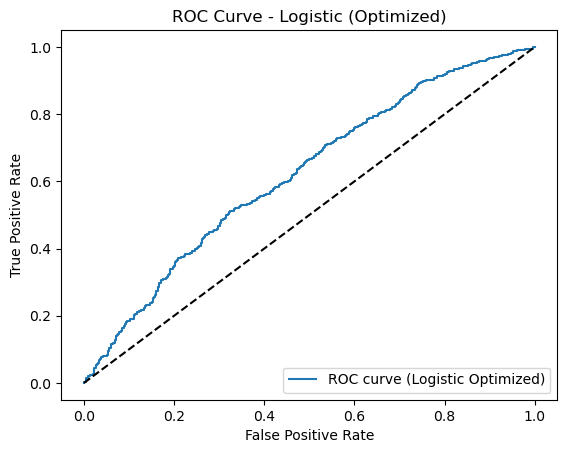

ROC-AUC Score: 0.6206777359936366


In [110]:
y_pred_prob_Log_opt = final_Logistic.predict_proba(X_model_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_Log_opt)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (Logistic Optimized)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic (Optimized)')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_Log_opt))

## 7.4 Classificador Gradient Boosting

In [119]:
model_GB = GradientBoostingClassifier(random_state=seed)
model_GB.fit(X_model, y_model)

predicted_GB = model_GB.predict(X_model_test)

accuracy_score(expected, predicted_GB)

0.6005586592178771

In [120]:
print(confusion_matrix(expected, predicted_GB))
print(classification_report(expected, predicted_GB))

[[279 332]
 [383 796]]
              precision    recall  f1-score   support

           0       0.42      0.46      0.44       611
           1       0.71      0.68      0.69      1179

    accuracy                           0.60      1790
   macro avg       0.56      0.57      0.56      1790
weighted avg       0.61      0.60      0.60      1790



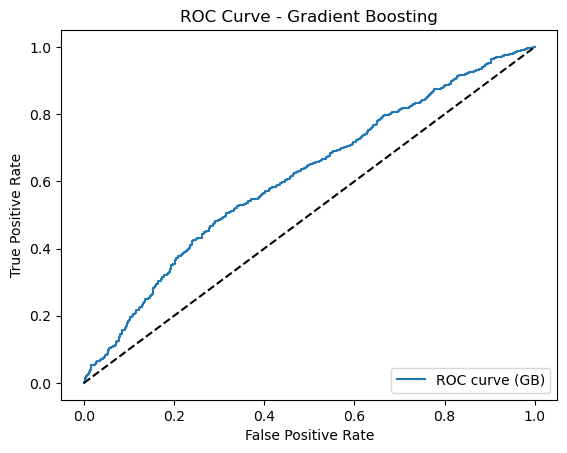

ROC-AUC Score: 0.6117614722454743


In [121]:
y_pred_prob_GB = model_GB.predict_proba(X_model_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_GB)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (GB)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_GB))

In [122]:
optm_GB = GradientBoostingClassifier(random_state=seed)

param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 500],
    'max_depth': [5, 8],
    'subsample': [0.9, 1.0],
    'max_features': [0.9, 1.0]
}

grid_search = GridSearchCV(optm_GB, param_grid=param_grid, 
                           scoring=make_scorer(f1_score, average='weighted'), cv=3, n_jobs=-1)

inicio = time.time()
grid_search.fit(X_model, y_model)
fin = time.time()
print(f"The grid search took {(fin - inicio)/60:.2f} minutes to run.")

The grid search took 7.39 minutes to run.


In [123]:
print("Best parameters:", grid_search.best_params_)
print("Best weighted F1 score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 8, 'max_features': 1.0, 'n_estimators': 500, 'subsample': 0.9}
Best weighted F1 score: 0.6143783320231025


In [130]:
results_df = pd.DataFrame(grid_search.cv_results_)
top_10_models = results_df.nlargest(10, "mean_test_score")

print("\nTop 10 models:")
for index, row in top_10_models.iterrows():
    print(f"\nModel {index+1}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean test score: {row['mean_test_score']:.4f}")


Top 10 models:

Model 15:
Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'max_features': 1.0, 'n_estimators': 500, 'subsample': 0.9}
Mean test score: 0.6144

Model 11:
Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'max_features': 0.9, 'n_estimators': 500, 'subsample': 0.9}
Mean test score: 0.6143

Model 27:
Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'max_features': 0.9, 'n_estimators': 500, 'subsample': 0.9}
Mean test score: 0.6106

Model 12:
Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'max_features': 0.9, 'n_estimators': 500, 'subsample': 1.0}
Mean test score: 0.6097

Model 13:
Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'max_features': 1.0, 'n_estimators': 100, 'subsample': 0.9}
Mean test score: 0.6094

Model 31:
Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'max_features': 1.0, 'n_estimators': 500, 'subsample': 0.9}
Mean test score: 0.6067

Model 16:
Parameters: {'learning_rate': 0.05, 'max_depth': 8, 'max_features': 1.0, 'n_estimators': 500,

In [131]:
params_final_GB = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 8,
    'subsample': 0.9,
    'max_features': 1.0,
    'random_state': seed
}

final_GB = GradientBoostingClassifier(**params_final_GB)

In [132]:
final_GB.fit(X_model, y_model)

predicted_GB_opt = final_GB.predict(X_model_test)
accuracy_score(expected, predicted_GB_opt)

0.5899441340782123

In [133]:
print(confusion_matrix(expected, predicted_GB_opt))
print(classification_report(expected, predicted_GB_opt))

[[262 349]
 [385 794]]
              precision    recall  f1-score   support

           0       0.40      0.43      0.42       611
           1       0.69      0.67      0.68      1179

    accuracy                           0.59      1790
   macro avg       0.55      0.55      0.55      1790
weighted avg       0.60      0.59      0.59      1790



In [134]:
op_thres_GB = 0.5
probs_GB_opt = final_GB.predict_proba(X_model_test)[:, 1]  
pred_thres_GB_opt = (probs_GB_opt >= op_thres_GB).astype(int)

print(confusion_matrix(expected, pred_thres_GB_opt))
print(classification_report(expected, pred_thres_GB_opt))

[[262 349]
 [385 794]]
              precision    recall  f1-score   support

           0       0.40      0.43      0.42       611
           1       0.69      0.67      0.68      1179

    accuracy                           0.59      1790
   macro avg       0.55      0.55      0.55      1790
weighted avg       0.60      0.59      0.59      1790



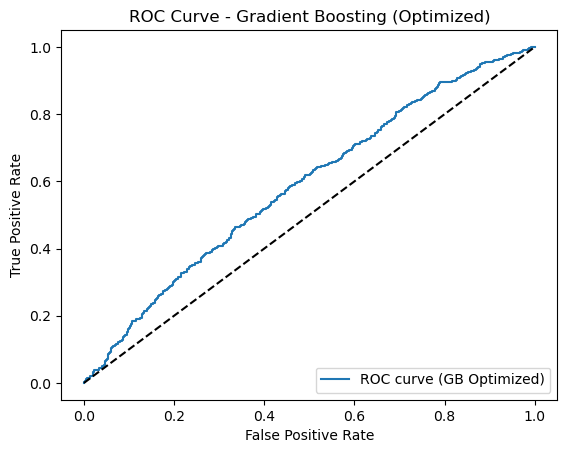

ROC-AUC Score: 0.5864924781604983


In [135]:
y_pred_prob_GB_opt = final_GB.predict_proba(X_model_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_GB_opt)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (GB Optimized)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting (Optimized)')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob_GB_opt))

# 8. Exportar CSV

## 8.1 Asignacion de las variables

Asignamos las variables para el analisis en función del desarrollo del apartado del preprocesado.

In [145]:
X_kaggle = X_res_final
y_kaggle = y_res_final

X_kaggle_test = X_scaled_te_final

## 8.2 Clasificador Logistic Regression

In [149]:

probs_For_final = final_Logistic.predict_proba(X_kaggle_test)[:, 1]  
pred_thres_For_final = (probs_For_final >= 0.5).astype(int) 

In [153]:
df_label_Logistic = pd.DataFrame(pred_thres_For_final, columns=['label'])

In [155]:
df_id = df_test['id'].reset_index(drop=True)

In [157]:
df_final_Logistic = pd.concat([df_id, df_label_Logistic], axis=1)

In [159]:
df_final_Logistic['label'].value_counts()

label
1    2239
0    1597
Name: count, dtype: int64

In [161]:
df_final_Logistic.to_csv('./submit/LogisticWord2vec.csv', index=False)

## 8.3 Clasificador GradientBoosting

In [166]:
probs_GB_final = final_GB.predict_proba(X_kaggle_test)[:, 1]  
pred_thres_GB_final = (probs_GB_final >= 0.40).astype(int) 

In [169]:
df_label_GB = pd.DataFrame(pred_thres_GB_final, columns=['label'])

In [171]:
df_id = df_test['id'].reset_index(drop=True)

In [178]:
df_final_GB = pd.concat([df_id, df_label_GB], axis=1)

In [181]:
df_final_GB['label'].value_counts()

label
1    2673
0    1163
Name: count, dtype: int64

Se transforma el *dataframe* a un archivo *CSV*.

In [184]:
df_final_GB.to_csv('./submit/GBWord2vec.csv', index=False)